In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import urllib.request

original image


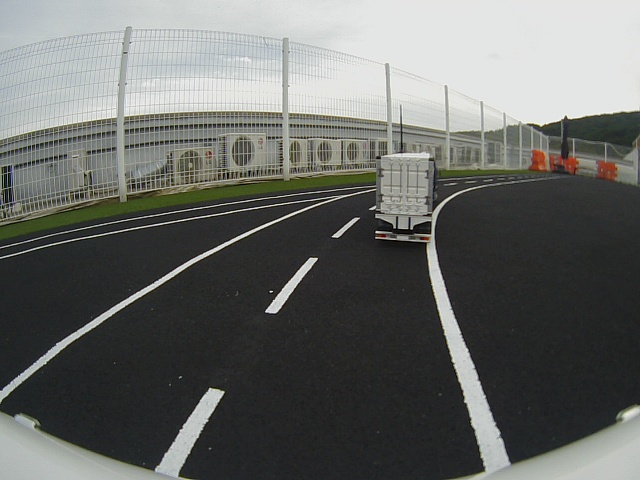

In [ ]:
# Load reference image
#image_url = 'https://i.postimg.cc/cJBd1cZ1/000.jpg'
image_url = 'https://i.postimg.cc/BbPG3b1T/001.jpg'

resp = urllib.request.urlopen(image_url)
numpy_image = np.asarray(bytearray(resp.read()), dtype='uint8')
image = cv2.imdecode(numpy_image, cv2.IMREAD_COLOR)

print("original image")
cv2_imshow(image)

resized image


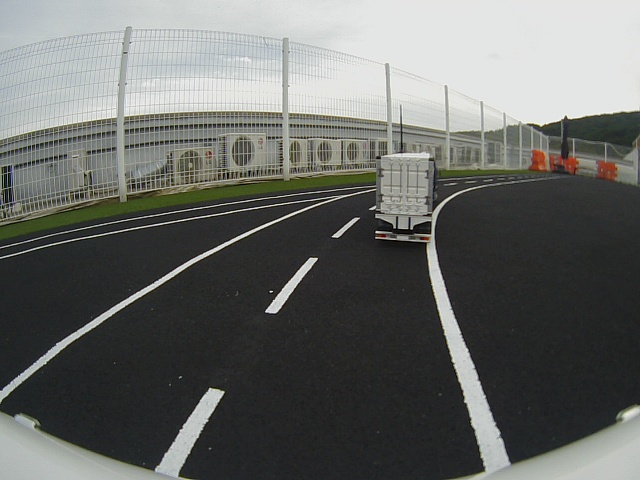

In [ ]:
width_ = 640
height_ = 480


# image resize
resized_image = cv2.resize(image, (width_, height_))

print("resized image")
cv2_imshow(resized_image)

warped image


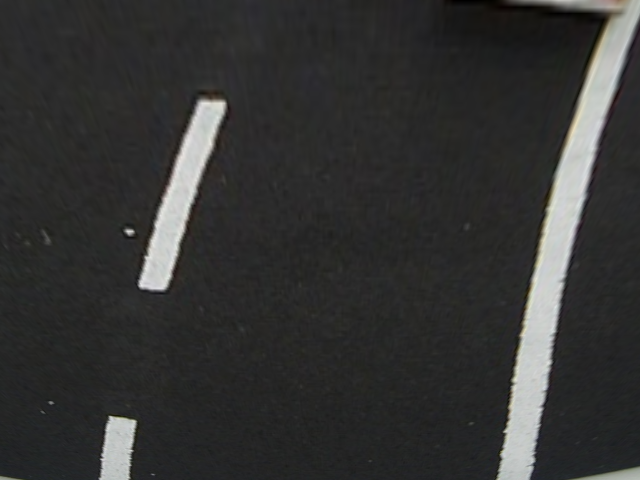

In [ ]:
top_gap_proportion = 0.42
bot_gap_proportion = 0.25
top_height_proportion = 0.50
bot_height_proportion = 0.95

width_offset = 20
#--파라미터수정
extra_up = 100
extra_down = 120

top_gap = width_ * top_gap_proportion;
bot_gap = width_ * bot_gap_proportion;
top_height = height_ * top_height_proportion;
bot_height = height_ * bot_height_proportion;

corners_ = np.float32([[top_gap + width_offset, top_height],
                    [(width_ - top_gap) + width_offset + 15, top_height],
                    [bot_gap + width_offset, bot_height],
                    [(width_ - bot_gap) + width_offset, bot_height]])
#이동시킬 위치
warpCorners_ = np.float32([[extra_up, 0.0],
                        [width_ - extra_up, 0.0],
                        [extra_down, height_],
                        [width_ - extra_down, height_]])


# image warp
trans_matrix = cv2.getPerspectiveTransform(corners_, warpCorners_)
warped_image = cv2.warpPerspective(resized_image, trans_matrix, (width_, height_))

print("warped image")
cv2_imshow(warped_image)

blur image


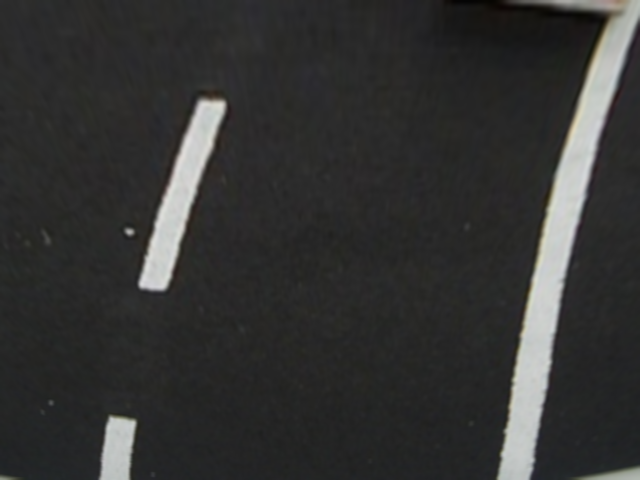

max blur image


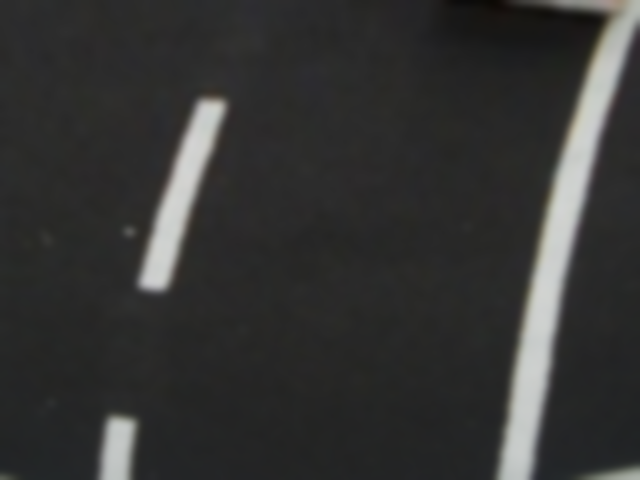

In [ ]:
# image blur
blur_image = cv2.GaussianBlur(warped_image, (5, 5), 0, 0, cv2.BORDER_DEFAULT)

print("blur image")
cv2_imshow(blur_image)

# blur 효과 체험하기
blur_image_show = cv2.GaussianBlur(warped_image, (25, 25), 0, 0, cv2.BORDER_DEFAULT)

print("max blur image")
cv2_imshow(blur_image_show)

gray image


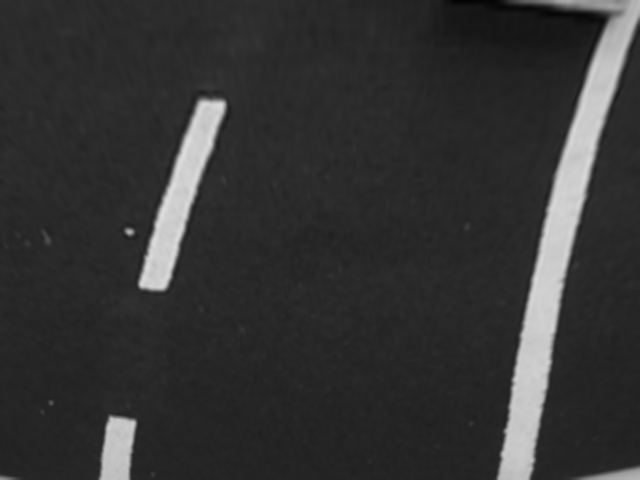

In [ ]:
# image gray 사진편집용이
gray_image = cv2.cvtColor(blur_image, cv2.COLOR_BGR2GRAY)

print("gray image")
cv2_imshow(gray_image)

binary image


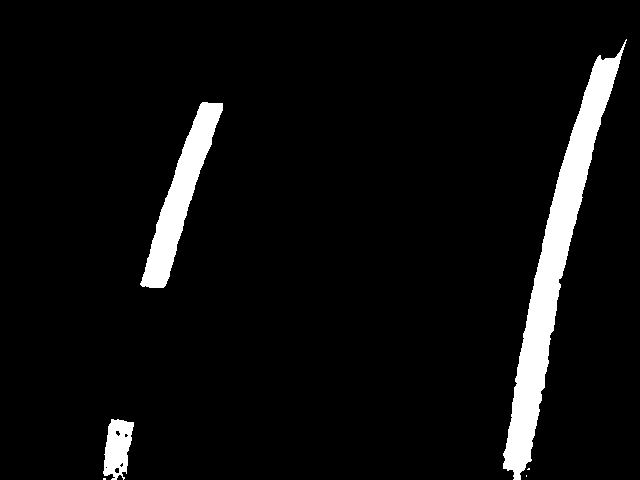

In [ ]:
threshold_ = 190
max_value_ = 255


# image binary
ret, binary_image = cv2.threshold(gray_image, threshold_, max_value_, cv2.THRESH_BINARY)  # cv2.THRESH_BINARY : 픽셀 값이 threshold_을 초과할 경우 max_value_, 아니면 0.

print("binary image")
cv2_imshow(binary_image)

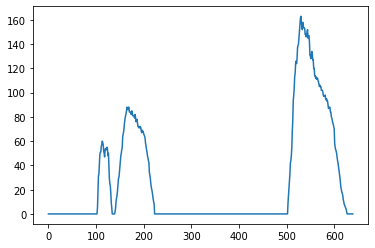

In [ ]:
hist = np.zeros(width_)
#중앙값 찾기 위해
for height in np.arange(0, height_, 1):
  for width in np.arange(0, width_, 1):
    if (binary_image.item(height, width) == 255):
        hist[width] += 1

x_angle = np.arange(0, width_, 1)
plt.plot(x_angle, hist) # opencv는 위쪽 pixel의 index가 0이다.
plt.show()

In [ ]:
mid_point = int(width_ / 2)

Left_start_pixel = 50
Left_end_pixel = int(mid_point - 100)
Right_start_pixel = int(mid_point + 100)
Right_end_pixel = int(width_ - 50)


if (np.max(hist[Left_start_pixel: Left_end_pixel]) > 0):
  Llane_base = np.argmax(hist[Left_start_pixel: Left_end_pixel]) + Left_start_pixel
else:
  Llane_base = -1

if (np.max(hist[Right_start_pixel: Right_end_pixel]) > 0):
  Rlane_base = np.argmax(hist[Right_start_pixel: Right_end_pixel]) + Right_start_pixel
else:
  Rlane_base = -1

print("Llane_base : {}".format(Llane_base))
print("Rlane_base : {}".format(Rlane_base))

Llane_base : 165
Rlane_base : 530


In [ ]:
prev_Llane_current_ = 160  # 첫 frame을 위한 설정
prev_Rlane_current_ = 480


if (Llane_base != -1):
  Llane_current = Llane_base
else:
  Llane_current = prev_Llane_current_

if (Rlane_base != -1):
  Rlane_current = Rlane_base
else:
  Rlane_current = prev_Rlane_current_

prev_Llane_current_ = Llane_current
prev_Rlane_current_ = Rlane_current

print("Llane_current : {}".format(Llane_base))
print("Rlane_current : {}".format(Rlane_base))

Llane_current : 165
Rlane_current : 530


sliding windows image


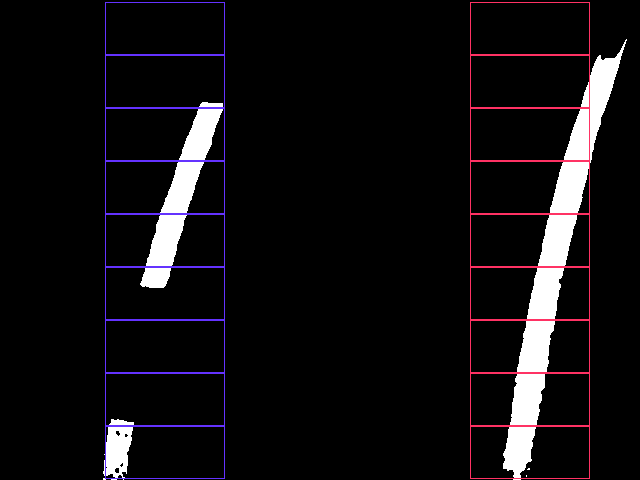

In [ ]:
n_windows = 9

margin = int(120 * width_ / 1280)
min_pix = int(30 * width_ / 1280)

window_width = int(margin * 2)
window_height = int(height_ / n_windows)


# sliding window
sliding_window_image = cv2.cvtColor(binary_image, cv2.COLOR_GRAY2BGR)

for window in np.arange(0, n_windows, 1):
  Ly_pos = height - (window + 1) * window_height
  Ry_pos = height - (window + 1) * window_height
  Ly_top = height - window * window_height
  Ry_top = height - window * window_height

  Lx_pos = Llane_current - margin
  Rx_pos = Rlane_current - margin

  cv2.rectangle(sliding_window_image, (Lx_pos, Ly_pos, window_width, window_height), (255, 50, 100), 1)
  cv2.rectangle(sliding_window_image, (Rx_pos, Ry_pos, window_width, window_height), (100, 50, 255), 1)

print("sliding windows image")
cv2_imshow(sliding_window_image)

In [ ]:
# detect white points
nonZero = cv2.findNonZero(binary_image)
print("number of white points : {}\n\n".format(nonZero.shape))

number of white points : (17428, 1, 2)




detected points image


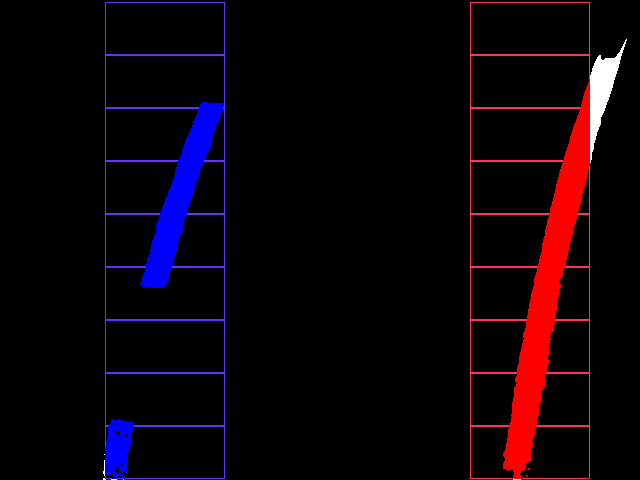

In [ ]:
# filter white points by sliding window
detected_points_image = sliding_window_image.copy()

for window in np.arange(0, n_windows, 1):
  Ly_pos = height - (window + 1) * window_height
  Ry_pos = height - (window + 1) * window_height
  Ly_top = height - window * window_height
  Ry_top = height - window * window_height

  Lx_pos = Llane_current - margin
  Rx_pos = Rlane_current - margin

  for index in np.arange((len(nonZero) - 1), 1, -1):
    nonZero_y = nonZero[index][0][1]
    nonZero_x = nonZero[index][0][0]

    if ((nonZero_y >= Ly_pos) and (nonZero_y < Ly_top) and (nonZero_x >= Lx_pos) and (nonZero_x < (Lx_pos + window_width))):
      detected_points_image[nonZero[index][0][1], nonZero[index][0][0]] = [255, 0, 0]  # (y, x)
      # good_left_inds.append(index)  아래에서 실행

    if ((nonZero_y >= Ry_pos) and (nonZero_y < Ry_top) and (nonZero_x >= Rx_pos) and (nonZero_x < (Rx_pos + window_width))):
      detected_points_image[nonZero[index][0][1], nonZero[index][0][0]] = [0, 0, 255]  # (y, x)
      # good_right_inds.append(index)  아래에서 실행

print("detected points image")
cv2_imshow(detected_points_image)

sliding windows image


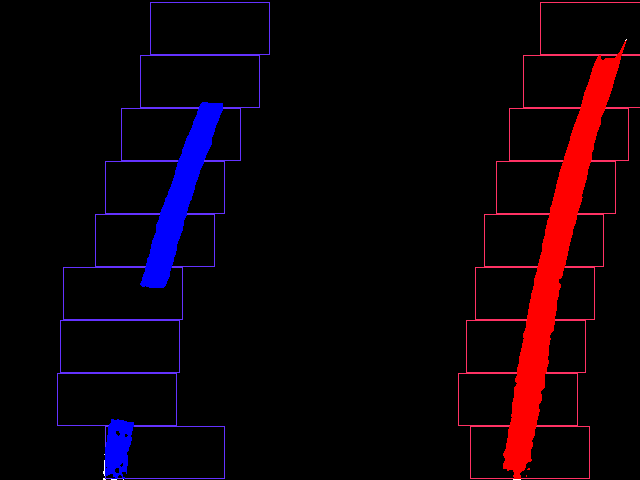

In [ ]:
from numpy.lib import index_tricks

R_gap = 0
L_gap = 0

Llane_x = []
Llane_y = []
Rlane_x = []
Rlane_y = []

left_x_ = []
left_y_ = []
right_x_ = []
right_y_ = []
center_x_ = []
center_y_ = []

sliding_window_image = cv2.cvtColor(binary_image, cv2.COLOR_GRAY2BGR)

# 위에서 한 부분 -----------------------------------------------------------------------------------------------------------
for window in np.arange(0, n_windows, 1):
  Ly_pos = height - (window + 1) * window_height
  Ry_pos = height - (window + 1) * window_height
  Ly_top = height - window * window_height
  Ry_top = height - window * window_height

  Lx_pos = Llane_current - margin
  Rx_pos = Rlane_current - margin

  cv2.rectangle(sliding_window_image, (Lx_pos, Ly_pos, window_width, window_height), (255, 50, 100), 1)
  cv2.rectangle(sliding_window_image, (Rx_pos, Ry_pos, window_width, window_height), (100, 50, 255), 1)

  good_left_inds = []
  good_right_inds = []

  for index in np.arange((len(nonZero) - 1), 1, -1):
    nonZero_y = nonZero[index][0][1]
    nonZero_x = nonZero[index][0][0]

    if ((nonZero_y >= Ly_pos) and (nonZero_y < Ly_top) and (nonZero_x >= Lx_pos) and (nonZero_x < (Lx_pos + window_width))):
      sliding_window_image[nonZero[index][0][1], nonZero[index][0][0]] = [255, 0, 0]  # (y, x)
      good_left_inds.append(index)  # 왼쪽 white pixel의 위치

    if ((nonZero_y >= Ry_pos) and (nonZero_y < Ry_top) and (nonZero_x >= Rx_pos) and (nonZero_x < (Rx_pos + window_width))):
      sliding_window_image[nonZero[index][0][1], nonZero[index][0][0]] = [0, 0, 255]  # (y, x)
      good_right_inds.append(index)  # 오른쪽 white pixel의 위치
# ---------------------------------------------------------------------------------------------------------------------------

# 왼쪽 차선 분류
  if (len(good_left_inds) > min_pix):
    Lsum = 0
    _size = len(good_left_inds)

    for Ly_raw_points in np.arange((Ly_top - 1), (Ly_pos - 1), -1):
      Lx_sum = 0
      count = 0

      for index in np.arange(0, _size, 1):
        Ly_point = nonZero[good_left_inds[index]][0][1]
        if (Ly_raw_points == Ly_point):
          Lx_sum += nonZero[good_left_inds[index]][0][0]
          Lsum += nonZero[good_left_inds[index]][0][0]
          count += 1
      
      if (count != 0 ):
        Llane_x.append(int(Lx_sum / count))
        Llane_y.append(Ly_raw_points)
        left_x_.append(int(Lx_sum / count))
        left_y_.append(Ly_raw_points)
      else:
        Llane_x.append(-1)
        Llane_y.append(Ly_raw_points)

    Llane_current = int(Lsum / _size)  # Average value all of points in sliding-window

  else:
    for Ly_raw_points in np.arange((Ly_top - 1), Ly_pos, -1):
      Llane_x.append(-1)  # No value in each y-axis of sliding-window
      Llane_y.append(Ly_raw_points)

    Llane_current += L_gap

  if (window):
    L_gap = (Llane_current - L_prev)

  L_prev = Llane_current

# 오른쪽 차선 분류
  if (len(good_right_inds) > min_pix):
    Rsum = 0
    _size = len(good_right_inds)

    for Ry_raw_points in np.arange((Ry_top - 1), (Ry_pos - 1), -1):
      Rx_sum = 0
      count = 0

      for index in np.arange(0, _size, 1):
        Ry_point = nonZero[good_right_inds[index]][0][1]
        if (Ry_raw_points == Ry_point):
          Rx_sum += nonZero[good_right_inds[index]][0][0]
          Rsum += nonZero[good_right_inds[index]][0][0]
          count += 1
      
      if (count != 0 ):
        Rlane_x.append(int(Rx_sum / count))
        Rlane_y.append(Ry_raw_points)
        right_x_.append(int(Rx_sum / count))
        right_y_.append(Ry_raw_points)
      else:
        Rlane_x.append(-1)
        Rlane_y.append(Ry_raw_points)

    Rlane_current = int(Rsum / _size)  # Average value all of points in sliding-window

  else:
    for Ry_raw_points in np.arange((Ry_top - 1), Ry_pos, -1):
      Rlane_x.append(-1)  # No value in each y-axis of sliding-window
      Rlane_y.append(Ry_raw_points)

    Rlane_current += R_gap

  if (window):
    R_gap = (Rlane_current - R_prev)

  R_prev = Rlane_current

# 가상 중앙점 생성
  for index in np.arange(0, min(len(Llane_x), len(Rlane_x)), 1):
    if ((Llane_x[index] != -1) and (Rlane_x[index] != -1)):
      center_x_.append(int((Llane_x[index] + Rlane_x[index]) / 2))
      center_y_.append(Llane_y[index])

print("sliding windows image")
cv2_imshow(sliding_window_image)

In [ ]:
# 다항식 곡선 피팅
if (len(left_x_) != 0):
  left_coef_ = np.polyfit(left_y_, left_x_, 2)
else:
  left_coef_ = 0

if (len(right_x_) != 0):
  right_coef_ = np.polyfit(right_y_, right_x_, 2)
else:
  right_coef_ = 0

#if ((len(left_x_) != 0) and (len(right_x_) != 0)):
#  center_coef_ = np.polyfit(center_y_, center_x_, 2)
#else:
#  center_coef_ = 0

In [ ]:
left_point = []
right_point = []
center_point = []


# 곡선 생성
if (len(left_coef_) and len(right_coef_)):
  for i in np.arange(0, height_ + 1, 1):
    temp_left_point = np.array([int((left_coef_[0] * pow(i, 2)) + (left_coef_[1] * i) + left_coef_[2]), int(i)]).astype(np.int32)
    temp_right_point = np.array([int((right_coef_[0] * pow(i, 2)) + (right_coef_[1] * i) + right_coef_[2]), int(i)]).astype(np.int32)
    #temp_center_point = np.array([int((center_coef_[0] * pow(i, 2)) + (center_coef_[1] * i) + center_coef_[2]), int(i)]).astype(np.int32)
    temp_center_point = np.array([int(((left_coef_[0] * pow(i, 2)) + (left_coef_[1] * i) + left_coef_[2] + right_coef_[0] * pow(i, 2) + (right_coef_[1] * i) + right_coef_[2])/2), int(i)]).astype(np.int32)

    left_point.append(temp_left_point)
    right_point.append(temp_right_point)
    center_point.append(temp_center_point)

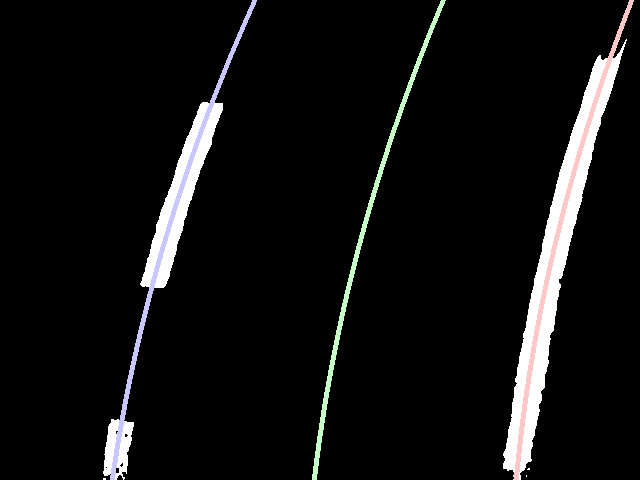

In [ ]:
left_points = []
right_points = []
center_points = []


# 곡선 그리기
result2 = cv2.cvtColor(binary_image, cv2.COLOR_GRAY2BGR)

if (len(left_coef_) and len(right_coef_)):
  left_points = np.array(left_point)
  left_points = left_points.reshape((-1, 1, 2))
  cv2.polylines(result2, [left_points], False, (255, 200, 200), 3)

  right_points = np.array(right_point)
  right_points = right_points.reshape((-1, 1, 2))
  cv2.polylines(result2, [right_points], False, (200, 200, 255), 3)

  center_points = np.array(center_point)
  center_points = center_points.reshape((-1, 1, 2))
  cv2.polylines(result2, [center_points], False, (200, 255, 200), 3)

cv2_imshow(result2)

In [ ]:
reverse_left_point = []
reverse_right_point = []
reverse_center_point = []


# detected points를 원본 사진 각도로 바꾸기
reverse_trans_matrix = cv2.getPerspectiveTransform(warpCorners_, corners_)

left_points = np.float32(left_point)  # int형은 perspectiveTransform에서 에러 발생
left_points = left_points.reshape((-1, 1, 2))
right_points = np.float32(right_point)
right_points = right_points.reshape((-1, 1, 2))
center_points = np.float32(center_point)
center_points = center_points.reshape((-1, 1, 2))

reverse_left_point = cv2.perspectiveTransform(left_points, reverse_trans_matrix)
reverse_right_point = cv2.perspectiveTransform(right_points, reverse_trans_matrix)
reverse_center_point = cv2.perspectiveTransform(center_points, reverse_trans_matrix)

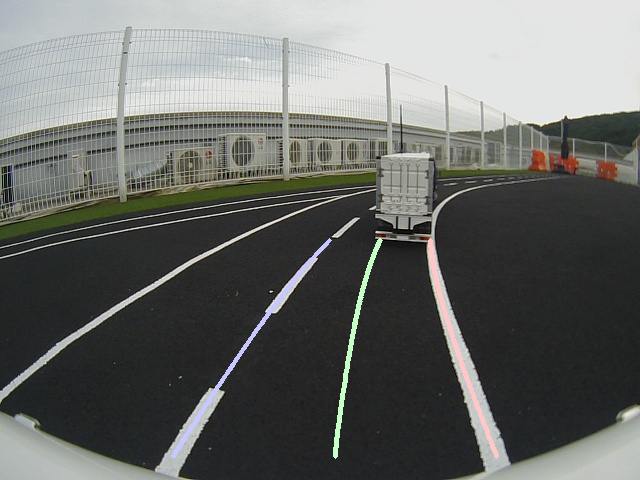

In [ ]:
result_image = resized_image.copy()


reverse_left_points = np.int32(reverse_left_point)
reverse_left_points = reverse_left_points.reshape((-1, 1, 2))
cv2.polylines(result_image, [reverse_left_points], False, (255, 200, 200), 3)

reverse_right_points = np.int32(reverse_right_point)
reverse_right_points = reverse_right_points.reshape((-1, 1, 2))
cv2.polylines(result_image, [reverse_right_points], False, (200, 200, 255), 3)

reverse_center_points = np.int32(reverse_center_point)
reverse_center_points = reverse_center_points.reshape((-1, 1, 2))
cv2.polylines(result_image, [reverse_center_points], False, (200, 255, 200), 3)

cv2_imshow(result_image)